 # Opis notatnika
 Ten notatnik jest kontunacją analizy danych o lotach i ich opóźnieniach. Od tego momentu zaczniemy łączyć posiadana przez nas zbiory danych, będąc w stanie dokonać dodatkowych analiz.

 Zanim jednak do tego przejdziemy, należy, podobnie jak w poprzednim kroku, skonfigurować odpowiednio notatnik.
 
 W tej części warsztatu ponownie wcielasz się w rolę Analiyka Danych, którego zadaniem jest wykonanie analizy eksplotacyjnej zbioru danych - jedno z wymagań dostarczonych przez klienta.

 Tutaj zaimportuj wymagane biblioteki

In [52]:
import pandas as pd
from psycopg2 import connect
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
import plotly.express as px

 ## Połączenie z bazą danych
 Tutaj uzupełnij konfigurację połączenia

In [3]:
username = 'postgres'
password = '123'

host = 'localhost'
database = 'airlines'
port = None


 Tutaj stwórz zmienną engine, która zostanie użyta do połączenia z bazą danych

In [4]:
url = URL.create(
    "postgresql",
    username = 'postgres',
    password = 'qpa102188523',
    host = 'localhost',
    database = 'airlines')
    
engine = create_engine(url)

 Tutaj uzupełnij implementację metody `read_sql_table`

In [125]:
def load_table_from_db(table_name):
    table_data = pd.read_sql_table(table_name, 
                             con=engine, 
                             index_col=None, 
                             coerce_float=True, 
                             parse_dates=None, 
                             columns=None, 
                             chunksize=None) #if chunksize is set it returns a generator object, not a df
    return table_data

 Tutaj zaczytaj zapisaną wcześniej ramkę danych `flight_df` do zmniennej o takiej samej nazwie

In [126]:
flight_df = pd.read_csv(r'..\data\processed\flight_df_01.csv')
flight_df.shape

(1057391, 31)

Sprawdzenie poprawności danych w ramce `flight_df` 

In [128]:
flight_df_expected_rows_amount = 1057391
flight_df_rows_amount = flight_df.shape[0]

assert flight_df_rows_amount == flight_df_expected_rows_amount, f'Oczekiwano {flight_df_expected_rows_amount} wierszy, otrzymano {flight_df_rows_amount}'

 # Wzbogacenie o `aircraft`
 Używając procedury `read_sql_table` wczytaj dane z tabeli `aircraft` i zapisz jako `aircraft_df`. Następnie:  
 1. Usuń z ramki kolumny `number_of_seats` oraz `id`. Na tej podstawie usuń nadmiarowe wiersze (duplikaty).  
 1. Następnie jeszcze raz sprawdź, czy dla kolumny `tail_num` nie występują duplikaty. Innymi słowy należy sprawdzić, czy dla jednego `tail_num` występuje więcej niż jeden rok produkcji.  
 1. Jeśli tak to:  
     - do ramki `aircraft_df_duplicated` zapisz powielone zgodnie ze sprawdzeniem wiersze,  
     - zgodnie z powyższym zmodyfikuj ramkę tak, aby w przypadku duplikatu za datę wytworzenia samolotu, uznana została najnowsza tj. jeśli dla `tail_num` są dostępne daty produkcji 1998 oraz 2001, uznajemy, że `tail_num` został wyprodukowany w `2001`.

 Wskazówki:
 - Praca z duplikatami na LMS: `Python - analiza danych -> Dzień 5 - Pandas -> Duplikaty`
 - Dokumentacja metody `duplicated`: [klik](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html)
 - Dokumentacja metody `drop_duplicates`: [klik](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html)

 Tutaj wczytaj tabelę `aircraft` używając `read_sql_table`

In [129]:
aircraft_df = load_table_from_db('aircraft')
aircraft_df.head()

,id,manufacture_year,tail_num,number_of_seats
0,0,1944,N54514,0.0
1,1,1945,N1651M,0.0
2,2,1953,N100CE,0.0
3,3,1953,N141FL,0.0
4,4,1953,N151FL,0.0


 Tutaj usuń kolumny `number_of_seats`, `id` oraz duplikaty z ramki `aircraft_df`

In [130]:
aircraft_df = aircraft_df.drop(['number_of_seats', 'id'], axis=1)

#aircraft_df.shape #(7383, 2)

aircraft_df = aircraft_df.drop_duplicates()

aircraft_df.shape #(7364, 2)

(7364, 2)

 ### Sprawdzenie
 Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

In [131]:
aircraft_df_expected_rows = 7364
aircraft_df_expected_columns = set(['tail_num', 'manufacture_year'])

aircraft_df_rows = aircraft_df.shape[0]

diff = aircraft_df_expected_columns.symmetric_difference(set(aircraft_df.columns))
assert aircraft_df_rows == aircraft_df_expected_rows, f'Spodziewano się {aircraft_df_expected_rows} wierszy , otrzymano {aircraft_df_rows} wierszy'

assert diff == set([]), f'Spodziewano się {aircraft_df_expected_columns} kolumn, otrzymano: {aircraft_df_expected_columns} kolumn. Różnica: \n\t{diff}'

 Tutaj sprawdź czy w ramkce `aircraft_df` występują duplikaty wewnątrz kolumny `tail_num`. Czyli czy dla danego `tail_num` występuje więcej niż jeden rok produkcji.

In [132]:
aircraft_df_is_duplicated = aircraft_df.duplicated(subset='tail_num')
aircraft_df_duplicated = aircraft_df.loc[aircraft_df_is_duplicated]

 ### Sprawdzenie
 Uruchom kod poniżej, aby sprawdzić czy ta część została poprawnie wykonana

In [133]:
aircraft_df_expected_rows = 3
aircraft_df_duplicated_rows = aircraft_df_duplicated.shape[0]
assert aircraft_df_duplicated_rows == aircraft_df_expected_rows, f"Oczekiwano {aircraft_df_expected_rows} wierszy, otrzymano {aircraft_df_duplicated_rows}"

 ## Modyfikacja `aircraft_df`
 Tutaj dokonaj aktualizacji tabeli `aircraft_df` - jeśli jest taka potrzeba. Zrób to tak aby, dla powielonych `tail_num`, `manufacture_year` został ustawiony jako najwyższy

In [134]:
duplicate_count = aircraft_df.duplicated(subset='tail_num').sum()
duplicate_count

3

In [135]:
aircraft_df['tail_num'].value_counts()

tail_num
N783CA    2
N856GT    2
N877AS    2
N54514    1
N871NN    1
         ..
N862AS    1
N881AS    1
N870AS    1
N871AS    1
N2749U    1
Name: count, Length: 7361, dtype: int64

In [136]:
dupl = aircraft_df[aircraft_df['tail_num'].isin(['N783CA', 'N856GT', 'N877AS'])]
dupl.sort_values('tail_num')

,manufacture_year,tail_num
1734,1999,N783CA
2086,2000,N783CA
4917,2011,N856GT
5725,2014,N856GT
2460,2001,N877AS
6746,2017,N877AS


In [137]:
for tail_num in aircraft_df['tail_num'].unique():
    max_manufacture_year = aircraft_df[aircraft_df['tail_num'] == tail_num]['manufacture_year'].max()
    
    # Update the DataFrame with the max_manufacture_year value
    aircraft_df.loc[aircraft_df['tail_num'] == tail_num, 'manufacture_year'] = max_manufacture_year


aircraft_df

,manufacture_year,tail_num
0,1944,N54514
1,1945,N1651M
2,1953,N100CE
3,1953,N141FL
4,1953,N151FL
...,...,...
7378,2019,N14011
7379,2019,N16008
7380,2019,N16009
7381,2019,N2250U


In [138]:
dupl_check = aircraft_df[aircraft_df['tail_num'].isin(['N783CA', 'N856GT', 'N877AS'])]
dupl_check.sort_values('tail_num')

,manufacture_year,tail_num
1734,2000,N783CA
2086,2000,N783CA
4917,2014,N856GT
5725,2014,N856GT
2460,2017,N877AS
6746,2017,N877AS


 ### Sprawdzenie
 Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

In [139]:
test_tail = 'N783CA'
test_value = aircraft_df.loc[aircraft_df['tail_num']
                             == test_tail]['manufacture_year']
test_value = int(test_value)

expected_value = 2000
assert test_value == expected_value, f"Dla 'tail_num' == '{test_tail}' oczekiwano {expected_value} otrzymano {test_value}"

TypeError: cannot convert the series to <class 'int'>

In [140]:
type(test_value)

pandas.core.series.Series

 ## Połączenie `aircraft_df` oraz `flight_df`
 Połącz ramkę `aircraft_df` oraz `flight_df` zgodnie z kluczem oraz odpowiedz na następujące pytania:
 1. Czy po połączeniu pojawiły się duplikaty? Dokonaj odpowiedniego sprawdzenia.
 1. Wyznacz zależność roku produkcji do częstotliwości opóźnień. Wynik zapisz do tabeli `delays_by_manufacture_year_df`.
 1. Przedstaw wyniki w tabeli za pomocą wykresu punktowego.
 1. Dokonaj modyfikacji w taki sposób, aby wyświetlone na wykresie zostały tylko takie roczniki samolotów, które wykonały łącznie więcej niż 10000 `(>)` lotów.

> **Wskazówka:**
> Aby nie utracić potencjalnie całej dotychczasowej pracy, zapisz wynik do tymczasowej zmiennej np. `tmp_flight_df`. Po sprawdzeniu możesz użyć metody `copy`: [link](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html), aby nadpisać `flight_df` używając `tmp_flight_df`.

 Tutaj dokonaj złączenia `flight_df` z `aircraft_df`, wynik zapisz do `tmp_flight_df`

In [143]:
flight_df.columns

Index(['id', 'month', 'day_of_month', 'day_of_week', 'op_unique_carrier',
       'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id',
       'crs_dep_time', 'dep_time', 'dep_delay', 'dep_time_blk', 'crs_arr_time',
       'arr_time', 'arr_delay_new', 'arr_time_blk', 'cancelled',
       'crs_elapsed_time', 'actual_elapsed_time', 'distance', 'distance_group',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'year', 'is_delayed', 'is_weekend',
       'distance_agg'],
      dtype='object')

In [144]:
aircraft_df.head()

,manufacture_year,tail_num
0,1944,N54514
1,1945,N1651M
2,1953,N100CE
3,1953,N141FL
4,1953,N151FL


In [145]:
tmp_flight_df = pd.merge(flight_df, aircraft_df, on='tail_num', how='left')
tmp_flight_df.columns

Index(['id', 'month', 'day_of_month', 'day_of_week', 'op_unique_carrier',
       'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id',
       'crs_dep_time', 'dep_time', 'dep_delay', 'dep_time_blk', 'crs_arr_time',
       'arr_time', 'arr_delay_new', 'arr_time_blk', 'cancelled',
       'crs_elapsed_time', 'actual_elapsed_time', 'distance', 'distance_group',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'year', 'is_delayed', 'is_weekend',
       'distance_agg', 'manufacture_year'],
      dtype='object')

 Tutaj dokonaj sprawdzenia, czy nie pojawiły się duplikaty

In [146]:
duplicate_cnt = tmp_flight_df.duplicated().sum()
duplicate_cnt

17

In [147]:
tmp_flight_df.shape

(1057408, 32)

In [156]:
#should be 1057391 rows
tmp_flight_df = tmp_flight_df.drop_duplicates()
tmp_flight_df.shape 

(1057391, 32)

 Tutaj nadpisz `flight_df` używając `tmp_flight_df`

In [157]:
flight_df = tmp_flight_df.copy(deep=True)

 ## Opóźnienia vs. rok produkcji samolotu cz. 1
 Tutaj wyznacz zależność roku produkcji do częstotliwości opóźnień

In [158]:
delays_by_manufacture_year_df = flight_df.groupby('manufacture_year')['is_delayed'].sum().reset_index()

 Tutaj wyrysuj ramkę `delays_by_manufacture_year_df`

In [159]:
delays_by_manufacture_year_df['manufacture_year'] = delays_by_manufacture_year_df['manufacture_year'].astype(int)
delays_by_manufacture_year_df

,manufacture_year,is_delayed
0,1987,56
1,1988,115
2,1989,2
3,1990,744
4,1991,1400
5,1992,2444
6,1993,1045
7,1994,1207
8,1995,1500
9,1996,2320


 Tutaj zmodyfikuj wykres tak, aby prezentował tylko te roczniki, które odbyły więcej niż 10000 lotów

In [165]:
# checking the sum of all flights per manufacture year
sum_of_fligts_per_manufacture_year = flight_df.groupby('manufacture_year')['op_carrier_fl_num'].count().reset_index()
# sum_of_fligts_per_manufacture_year

#selecting only years where the total number of flights was higher than 10000
over_ten_thousand_flights = sum_of_fligts_per_manufacture_year[sum_of_fligts_per_manufacture_year['op_carrier_fl_num'] > 10000]
#over_ten_thousand_flights

# selecting from delays_by_manufacture_year_df(sum of delayed flights per manufacture year) 
# only the years that were in the over_ten_thousand_flights(total number of flights was higher than 10000)

delays_by_manufacture_year_df_over_ten = delays_by_manufacture_year_df[delays_by_manufacture_year_df['manufacture_year'].isin(over_ten_thousand_flights['manufacture_year'])]
delays_by_manufacture_year_df_over_ten


,manufacture_year,is_delayed
5,1992,2444
9,1996,2320
11,1998,7195
12,1999,8732
13,2000,10916
14,2001,15450
15,2002,7621
16,2003,3958
17,2004,7848
18,2005,8353


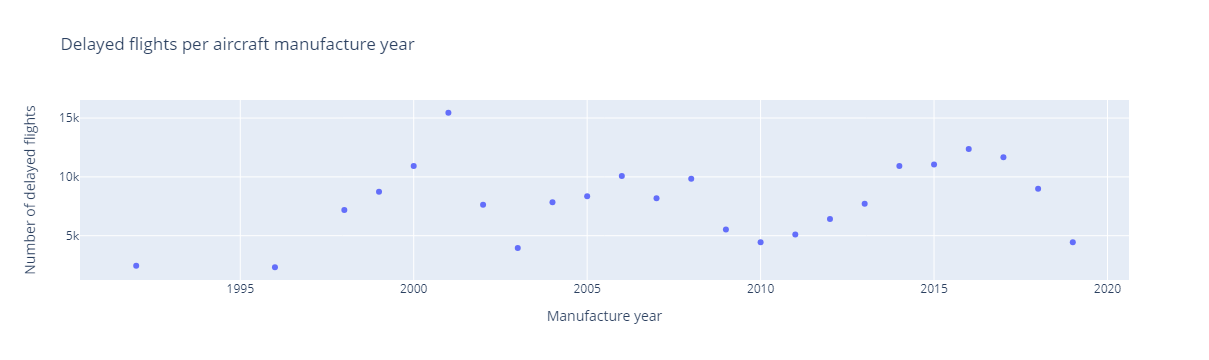

In [166]:
scatter_chart = px.scatter(delays_by_manufacture_year_df_over_ten, 
                  x='manufacture_year', 
                  y='is_delayed', 
                  labels={'manufacture_year': 'Manufacture year', 'is_delayed': 'Delayed'}, 
                  title='Delayed flights per aircraft manufacture year')

scatter_chart.update_xaxes(title_text= 'Manufacture year')
scatter_chart.update_yaxes(title_text='Number of delayed flights')

scatter_chart.show()

 ## Opóźnienia vs. rok produkcji samolotu cz. 2
 Dokonaj agregacji kolumny `manufacture_year` do kolumny `manufacture_year_agg` zgodnie z poniższym:
 1. Grupując dane co 3 lata -> Czy po grupowaniu można zauważyć zależność? Wyniki zapisz do ramki `flight_delays_by_manufacture_year_agg_df`.
 1. Wyznacz top 5 roczników samolotu, które wykonały najwięcej lotów. Wyniki zapisz do ramki `top_manufactured_df`, do obliczeń wykorzystaj `delays_by_manufacture_year_df`.

 Tutaj dodaj kolumnę `manufacture_year_agg` do ramki `flight_df`

In [106]:
# Define the bin edges for grouping every 3 years
bin_edges = list(range(int(flight_df['manufacture_year'].min()), int(flight_df['manufacture_year'].max()) + 4, 3))

# Define labels for the bins
bin_labels = [f'{start}-{start+2}' for start in bin_edges[:-1]]

# Create a new column 'manufacture_year_agg' based on the bins
delays_by_manufacture_year_df['manufacture_year_agg'] = pd.cut(delays_by_manufacture_year_df['manufacture_year'], bins=bin_edges, labels=bin_labels)

# Group the data by the 'manufacture_year_agg' column and aggregate the 'is_delayed' column by sum
flight_delays_by_manufacture_year_agg_df = delays_by_manufacture_year_df.groupby('manufacture_year_agg').agg({'is_delayed': 'sum'}).reset_index()

 Tutaj stwórz zmienną `flight_delays_by_manufacture_year_agg_df`

In [107]:
flight_delays_by_manufacture_year_agg_df

,manufacture_year_agg,is_delayed
0,1987-1989,861
1,1990-1992,4889
2,1993-1995,5027
3,1996-1998,17820
4,1999-2001,33987
5,2002-2004,20159
6,2005-2007,28122
7,2008-2010,15061
8,2011-2013,25045
9,2014-2016,35092


 Tutaj stwórz wykres w oparciu o dane zawarte w `flight_delays_by_manufacture_year_agg_df`

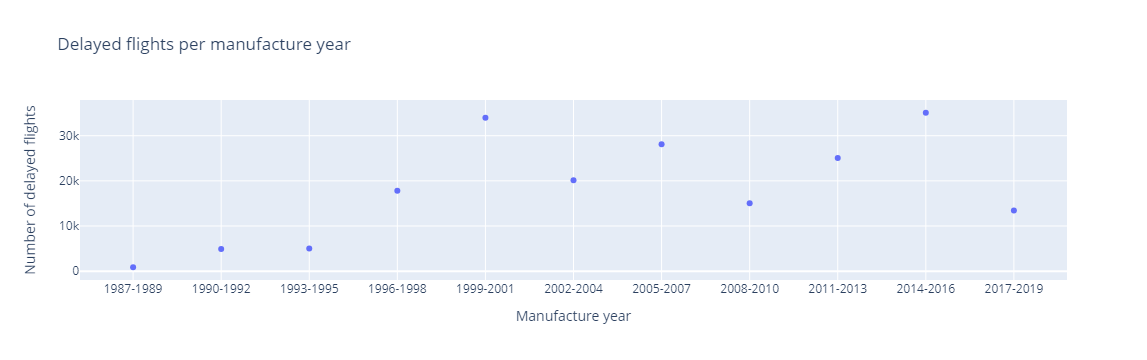

In [108]:
scatter_chart_agg = px.scatter(flight_delays_by_manufacture_year_agg_df, 
                               x='manufacture_year_agg', 
                               y='is_delayed', 
                               labels={'manufacture_year_agg': 'Manufacture year', 'is_delayed': 'Delayed'}, 
                               title='Delayed flights per manufacture year')

scatter_chart_agg.update_xaxes(title_text= 'Manufacture year')
scatter_chart_agg.update_yaxes(title_text='Number of delayed flights')

scatter_chart_agg.show()

Tutaj wyznacz TOP 5 roczników produkcji - czyli sortując według liczby wykonanych lotów, pamiętaj o wyświetleniu również wartości opóźnienia.

In [109]:
# Wyznacz top 5 roczników samolotu, które wykonały najwięcej lotów. Wyniki zapisz do ramki top_manufactured_df
top_manufactured_df = sum_of_fligts_per_manufacture_year.sort_values(by='op_carrier_fl_num', ascending=False).head(5).reset_index(drop=True)
top_manufactured_df

,manufacture_year,op_carrier_fl_num
0,2016.0,131792864
1,2008.0,124600127
2,2014.0,123164032
3,2015.0,118667690
4,2001.0,116329151


 # Podsumowanie
 W tym notatniku do naszej wyjściowej ramki danych `flight_df` dołączyliśmy tabelę `aircraft_df` i za jej pomocą dodaliśmy kolejny wymiar do naszej analizy. Zauważmy, ile dodatkowych wniosków mogliśmy wyciągnąć dzięki jej dodaniu.

 Zanim przejdziemy dalej, należy zapisać bieżącą postać ramki (najlepiej lokalnie), która zostanie użyta w kolejnym notatniku.

 > **Wskazówka:**  
 > Aby uniknąć potencjalnych problemów, najlepiej zapisać ramkę z nazwą nawiązującą do tego notatnika, np. `flight_df_01`.

 Tutaj zapisz ramkę w najdogodniejszy sposób

In [112]:
flight_df.to_csv(r'..\data\processed\flight_df_02.csv', index=False)